Using device: cuda
Mounted at /content/drive
Training dataset size: 527
Validation dataset size: 227
Test dataset size: 30
Classes: ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch [1/20], Training Loss: 0.512701, Training Accuracy: 80.08%
Validation Loss: 0.513967, Accuracy: 85.02%
Model saved at /content/drive/My Drive/FYP/ResNetHQ3/20250430/best_model.pth
Epoch [2/20], Training Loss: 0.315536, Training Accuracy: 83.68%
Validation Loss: 0.357410, Accuracy: 85.02%
Epoch [3/20], Training Loss: 0.297784, Training Accuracy: 88.24%
Validation Loss: 0.288620, Accuracy: 88.55%
Model saved at /content/drive/My Drive/FYP/ResNetHQ3/20250430/best_model.pth
Epoch [4/20], Training Loss: 0.236643, Training Accuracy: 90.32%
Validation Loss: 0.228248, Accuracy: 91.63%
Model saved at /content/drive/My Drive/FYP/ResNetHQ3/20250430/best_model.pth
Epoch [5/20], Training Loss: 0.217121, Training Accuracy: 90.51%
Validation Loss: 0.310716, Accuracy: 84.14%
Epoch [6/20], Training Loss: 0.210458, Training Accuracy: 91.84%
Validation Loss: 0.224948, Accuracy: 90.31%
Epoch [7/20], Training Loss: 0.195081, Training Accuracy: 91.65%
Validation Loss: 0.204551, Accuracy: 92.51%
Model 

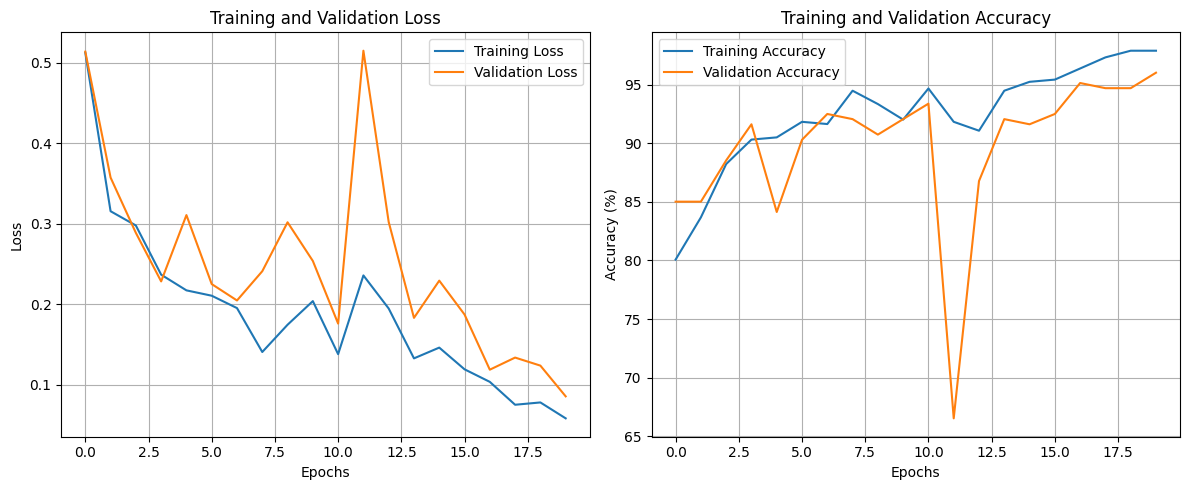

Test Loss: 0.167363, Test Accuracy: 93.33%


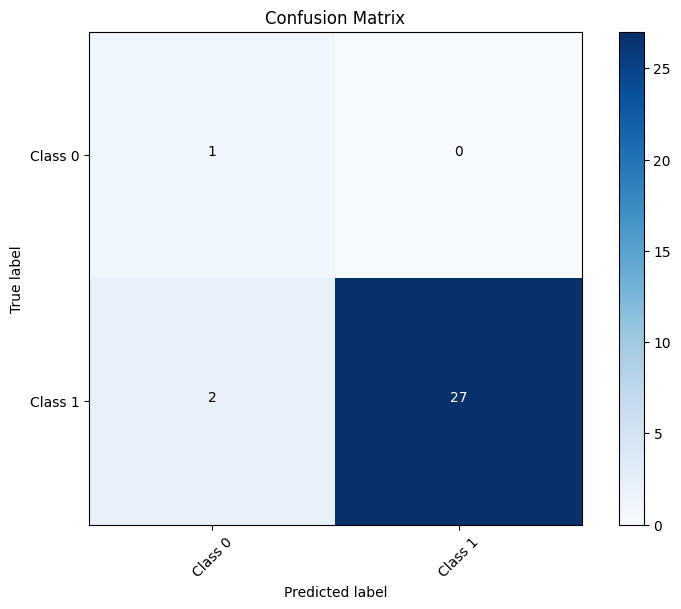

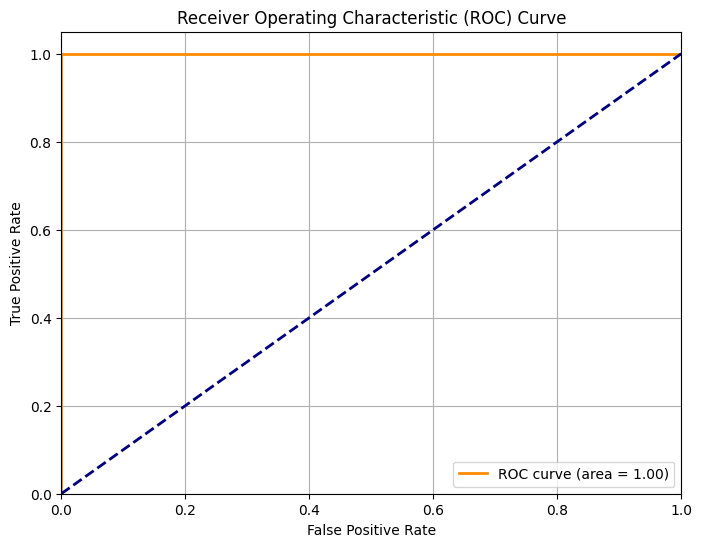

AttributeError: 'ImageFolder' object has no attribute 'dataset'

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from PIL import Image
import cv2
from datetime import datetime
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints and plots
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/ResNetHQ3/{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Create plots folder
plots_folder = os.path.join(checkpoint_folder, 'plots')
os.makedirs(plots_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16  # Use a larger batch size for better stability
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset information
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {train_loader.dataset.dataset.classes}")

# Define and modify Pretrained ResNet50 Model for Binary Classification with Dropout
class PretrainedResNet50(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(PretrainedResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Remove the original fully connected layer
        num_ftrs = self.resnet.fc.in_features

        # Replace with Dropout followed by a fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 2)  # 2 output classes (binary classification)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize the Pretrained ResNet50 model with dropout
model = PretrainedResNet50(dropout_rate=0.4).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training loop with metrics tracking for plots
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_val_acc = 0.0  # Initialize the best validation accuracy

    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Print the loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.6f}, Training Accuracy: {epoch_acc:.2f}%")

        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Learning rate scheduler
        scheduler.step(val_acc)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_model(model, checkpoint_folder, 'best_model.pth')

    # Save the final model after all epochs
    save_model(model, checkpoint_folder, 'final_model.pth')

    # Plot and save training/validation curves
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, plots_folder)

    return train_losses, val_losses, train_accuracies, val_accuracies

# Validation loop returning loss and accuracy
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Test function to evaluate on the test set with additional metrics and ROC curve
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions, labels, and probabilities for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(loader)
    print(f'Test Loss: {avg_loss:.6f}, Test Accuracy: {accuracy:.2f}%')

    # Generate and save confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, plots_folder)

    # Generate and save ROC curve
    plot_roc_curve(all_labels, all_probs, plots_folder)

    # Print classification report
    class_names = loader.dataset.dataset.classes
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return avg_loss, accuracy, all_labels, all_preds, all_probs

def save_model(model, folder_path, model_name):
    model_save_path = os.path.join(folder_path, model_name)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}")

def plot_learning_curves(train_losses, val_losses, train_accs, val_accs, save_dir):
    """Plot and save learning curves for loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'learning_curves.png'))
    plt.show()

def plot_confusion_matrix(cm, save_dir):
    """Plot and save confusion matrix."""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Class 0', 'Class 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.show()

def plot_roc_curve(y_true, y_score, save_dir):
    """Plot and save ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'))
    plt.show()

# Step 1: Train the model with metrics collection
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set with additional metrics
test_loss, test_acc, y_true, y_pred, y_score = test(model, test_loader, criterion)

# Step 3: Display a summary of results
print(f"\nTraining completed. Final results:")
print(f"Best validation accuracy: {max(val_accs):.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.6f}")

# Step 4: Plot learning rate changes
print("\nLearning rate changes during training:")
for i, param_group in enumerate(optimizer.param_groups):
    print(f"Final learning rate: {param_group['lr']}")